58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Step 1: Preparing Fashion-MNIST dataset...
Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saving training images...
Processed 1000 train images
Processed 2000 train images
Processed 3000 train images
Processed 4000 train images
Processed 5000 train images
Processed 6000 train images
Processed 7000 train images
Processed 8000 train images
Processed 9000 train images
Processed 10000 train images
Processed 11000 train images
Processed 12000 train images
Processed 13000 train images
Processed 14000 train images
Processed 15000 train images
Processed 16000 train images
Processed 17000 train images
Processed 18000 train images
Processed 19000 train images
Processed 20000 t

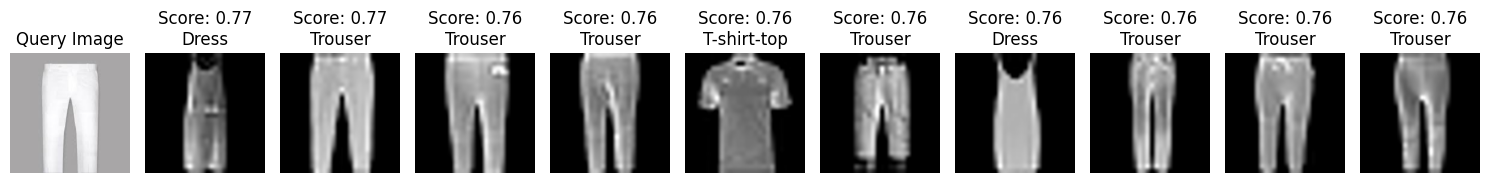

In [1]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16, EfficientNetB0, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

class FashionCBIR:
    def __init__(self, base_dir, image_size=(224, 224)):
        self.image_size = image_size
        self.base_dir = base_dir
        self.product_database = []
        self.feature_database = None
        self.label_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        
        # Load pre-trained models
        vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(image_size[0], image_size[1], 3))
        efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(image_size[0], image_size[1], 3))
        mobilenet = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(image_size[0], image_size[1], 3))

        # Freeze layers (no training needed)
        vgg16.trainable = False
        efficientnet.trainable = False
        mobilenet.trainable = False

        # Extract features from all models
        vgg_output = GlobalAveragePooling2D()(vgg16.output)
        efficient_output = GlobalAveragePooling2D()(efficientnet.output)
        mobile_output = GlobalAveragePooling2D()(mobilenet.output)

        # Concatenate features
        merged_features = Concatenate()([vgg_output, efficient_output, mobile_output])

        # Fully connected layers for feature refinement
        dense_1 = Dense(512, activation='relu')(merged_features)
        dense_2 = Dense(256, activation='relu')(dense_1)

        # Create the final feature extractor model
        self.model = Model(inputs=[vgg16.input, efficientnet.input, mobilenet.input], outputs=dense_2)

    def prepare_fashion_mnist(self):
        """Load and prepare Fashion-MNIST dataset"""
        print("Loading Fashion-MNIST dataset...")
        (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
        
        # Create directories for each category
        for label in self.label_names:
            category_dir = os.path.join(self.base_dir, label.replace("/", "-"))
            os.makedirs(category_dir, exist_ok=True)

        print("Saving training images...")
        self._save_dataset_images(train_images, train_labels, "train")
        
        print("Saving test images...")
        self._save_dataset_images(test_images, test_labels, "test")
        
        print(f"Dataset prepared and saved to {self.base_dir}")

    def _save_dataset_images(self, images, labels, prefix):
        """Helper function to save dataset images"""
        for i, (image, label) in enumerate(zip(images, labels)):
            img = Image.fromarray(image).convert('RGB')
            img = img.resize(self.image_size)
            
            category = self.label_names[label].replace("/", "-")
            filename = f'{prefix}_image_{i+1}.png'
            save_path = os.path.join(self.base_dir, category, filename)
            img.save(save_path)
            
            product_info = {
                'image_path': save_path,
                'category': category,
                'product_id': f'{prefix}_{i+1}',
                'label_index': label
            }
            self.product_database.append(product_info)
            
            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1} {prefix} images")

    def preprocess_image(self, image_path):
        """Preprocess image for feature extraction"""
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def extract_features(self):
        """Extract features for all products in database"""
        print("Extracting features for all products...")
        features = []
        total_products = len(self.product_database)
        
        for i, product in enumerate(self.product_database):
            img_processed = self.preprocess_image(product['image_path'])
            feature_vector = self.model.predict([img_processed, img_processed, img_processed], verbose=0)
            features.append(feature_vector.flatten())
            
            if (i + 1) % 1000 == 0:
                print(f"Processed features for {i + 1}/{total_products} products")
        
        self.feature_database = np.array(features)
        print("Feature extraction completed")

    def find_similar_products(self, query_image_path, num_results=10):
        """Find similar products for a given query image"""
        query_processed = self.preprocess_image(query_image_path)
        query_features = self.model.predict([query_processed, query_processed, query_processed], verbose=0).flatten()
        
        similarities = cosine_similarity([query_features], self.feature_database)
        similar_indices = np.argsort(similarities[0])[::-1][:num_results]
        
        similar_products = []
        for idx in similar_indices:
            product = self.product_database[idx].copy()
            product['similarity_score'] = similarities[0][idx]
            similar_products.append(product)
        
        return similar_products

    def display_results(self, query_image_path, similar_products):
        """Display query image and similar products"""
        num_results = len(similar_products)
        plt.figure(figsize=(15, 3 + num_results // 5))
        
        # Display query image
        plt.subplot(1, num_results + 1, 1)
        query_img = load_img(query_image_path, target_size=self.image_size)
        plt.imshow(query_img)
        plt.title('Query Image')
        plt.axis('off')
        
        # Display similar products
        for i, product in enumerate(similar_products):
            plt.subplot(1, num_results + 1, i + 2)
            img = load_img(product['image_path'], target_size=self.image_size)
            plt.imshow(img)
            plt.title(f"Score: {product['similarity_score']:.2f}\n{product['category']}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

def main():
    base_dir = '/content/fashion_mnist_images'  # Change this path as needed
    
    # Initialize CBIR system
    cbir = FashionCBIR(base_dir=base_dir)
    
    # Prepare Fashion-MNIST dataset (only needed once)
    print("Step 1: Preparing Fashion-MNIST dataset...")
    cbir.prepare_fashion_mnist()
    
    # Extract features for all products
    print("\nStep 2: Extracting features...")
    cbir.extract_features()
    
    # Example: Find similar products for a query image
    query_image_path = '/kaggle/input/pantdata/pant.jpeg'  # Change this path to your query image
    similar_products = cbir.find_similar_products(query_image_path, num_results=10)

    # Display results
    cbir.display_results(query_image_path, similar_products)

if __name__ == "__main__":
    main()
